Validation du modèle avec les données de 2023

### Preprocessing functions...

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

## TrackStatus ----------------------------------------------------------------

def trackStatus_to_binary(df):
    trackStatus = df['TrackStatus']
    status = pd.Series(
        np.zeros(6, dtype=np.bool8),
        index=['Green', 'Yellow', 'SC', 'Red', 'VSC', 'SC_ending']
    )
    if "1" in trackStatus:
        status['Green'] = True
    if "2" in trackStatus:
        status['Yellow'] = True
    if "4" in trackStatus:
        status['SC'] = True
    if "5" in trackStatus:
        status['Red'] = True
    if "6" in trackStatus:
        status['VSC'] = True
    if "7" in trackStatus:
        status['SC_ending'] = True
    return status

def process_trackStatus(df):
    trackStatuses = df.apply(trackStatus_to_binary, axis=1)
    return pd.concat([df.drop('TrackStatus', axis=1), trackStatuses], axis=1).reset_index(drop=True)

## Missing Data ----------------------------------------------------------------

def process_missing_values(df):
    # TODO fill the missing values better
    df.fillna({
        'DistanceToDriverAhead': -1,
        'GapToLeader': -1,
        'IntervalToPositionAhead': -1,
        'LapTime': -1,
    }, inplace=True)

    # drop all rows with missing laptime if pit status is not NoPit
    #df.dropna(subset=['LapTime'], inplace=True)
    #df.where(df['PitStatus'] != 'NoPit').fillna({'LapTime': -1,}, inplace=True)
    return df[df['LapNumber'] > 1]

## Datatypes -------------------------------------------------------------------

def process_datatypes(df):
    # boolean
    df['Green'] = df['Green'].astype('bool')
    df['Yellow'] = df['Yellow'].astype('bool')
    df['SC'] = df['SC'].astype('bool')
    df['Red'] = df['Red'].astype('bool')
    df['VSC'] = df['VSC'].astype('bool')
    df['SC_ending'] = df['SC_ending'].astype('bool')
    df['IsAccurate'] = df['IsAccurate'].astype('bool')
    df['Rainfall'] = df['Rainfall'].astype('bool')
    # category
    df['DriverNumber'] = df['DriverNumber'].astype('category')
    df['Team'] = df['Team'].astype('category')
    df['Compound'] = df['Compound'].astype('category')
    df['DriverAhead'] = df['DriverAhead'].astype('category')
    df['Track'] = df['Track'].astype('category')
    # float
    df['LapStartTime'] = df['LapStartTime'].astype('float32')
    df['LapTime'] = df['LapTime'].astype('float32')
    df['DistanceToDriverAhead'] = df['DistanceToDriverAhead'].astype('float32')
    df['GapToLeader'] = df['GapToLeader'].astype('float32')
    df['IntervalToPositionAhead'] = df['IntervalToPositionAhead'].astype('float32')
    df['AirTemp'] = df['AirTemp'].astype('float32')
    df['Humidity'] = df['Humidity'].astype('float32')
    df['Pressure'] = df['Pressure'].astype('float32')
    df['TrackTemp'] = df['TrackTemp'].astype('float32')
    df['WindDirection'] = df['WindDirection'].astype('float32')
    df['WindSpeed'] = df['WindSpeed'].astype('float32')
    # int
    df['LapNumber'] = df['LapNumber'].astype('uint8')
    df['TyreLife'] = df['TyreLife'].astype('uint8')
    df['Stint'] = df['Stint'].astype('uint8')
    df['NumberOfPitStops'] = df['NumberOfPitStops'].astype('uint8')
    df['Position'] = df['Position'].astype('uint8')
    df['LapsToLeader'] = df['LapsToLeader'].astype('uint8')
    df['TotalLaps'] = df['TotalLaps'].astype('uint8')
    return df

## Add target ------------------------------------------------------------------

def process_target(df):
    df['is_pitting'] = df['PitStatus'] == 'InLap'
    df['is_pitting'] = df['is_pitting'].astype('bool')
    return df

## Remove features -------------------------------------------------------------

def process_remove_features(df):
    df.drop(['LapStartTime', 'DriverNumber', 'Team', 'DriverAhead', 
    'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed',
    'PitStatus', 'IsAccurate'], axis=1, inplace=True)
    return df

## Feature encoding ------------------------------------------------------------

from sklearn.preprocessing import OneHotEncoder

def process_feature_encoding(df):
    categorical_features = ['Compound', 'Track']
    one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    one_hot_encoder.fit(df[categorical_features])
    one_hot_encoded = one_hot_encoder.transform(df[categorical_features])
    one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_features))
    print("One hot : ", one_hot_encoded.shape)
    print("Data : ", df.shape)
    df = df.join(one_hot_encoded)
    df.drop(categorical_features, axis=1, inplace=True)
    return df, one_hot_encoder


def process_feature_encoding_new(df, encoder):
    categorical_features = ['Compound', 'Track']
    one_hot_encoded = encoder.transform(df[categorical_features])
    one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_features))
    df = df.join(one_hot_encoded)
    df.drop(categorical_features, axis=1, inplace=True)
    return df

def preprocess_new_data(df, encoder):
    #print('Preprocessing data...', df.shape)
    df = process_trackStatus(df)
    #print('TrackStatus processed...', df.shape)
    df = process_missing_values(df)
    #print('Missing values processed...', df.shape)
    df = process_datatypes(df)
    #print('Datatypes processed...', df.shape)
    df = process_target(df)
    #print('Target processed...', df.shape)
    df = process_remove_features(df)
    #print('Features removed...', df.shape)
    df = process_feature_encoding_new(df, encoder)
    #print('Features encoded...', df.shape)
    return df

### 1. Chargement des données

In [15]:
# pandas display options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

base_path = 'data/2023'
encoder_path = 'models/sensitivity/encoder.pkl'
model_path = 'models/sensitivity/model.pkl'
figures_path = 'models/sensitivity/figures'

os.makedirs(figures_path, exist_ok=True)

type_dict ={
    'LapStartTime': np.float32,
    'LapNumber': np.uint8,
    'LapTime': np.float32,
    'DriverNumber': "category",
    'Team' : "category",
    'Compound': "category",
    'TyreLife': np.uint8,
    'TrackStatus': "category",
    'Stint': np.uint8,
    'DistanceToDriverAhead': np.float32,
    'DriverAhead': "category",
    'PitStatus': "category",
    'IsAccurate': np.bool8,
    'Track': "category",
    'NumberOfPitStops': np.uint8,
    'Position' : np.uint8,
    'GapToLeader' : np.float32,
    'IntervalToPositionAhead' : np.float32,
    'LapsToLeader' : np.uint8,
    'TotalLaps' : np.uint8,
    'AirTemp': np.float32,
    'Humidity': np.float32,
    'Pressure': np.float32,
    'TrackTemp': np.float32,
    'WindDirection': np.float32,
    'WindSpeed': np.float32
    }

In [16]:
data = pd.DataFrame()

# read all the data in base_path directory
for file in os.listdir(base_path):
    if file.endswith('.csv'):
        file_data = pd.read_csv(os.path.join(base_path, file), dtype=type_dict)
        if file_data['Rainfall'].any() == False:
            data = pd.concat([data, file_data], ignore_index=True)

In [17]:
encoder = pickle.load(open(encoder_path, 'rb'))
data_preprocessed = preprocess_new_data(data, encoder)
data_preprocessed.dropna(inplace=True)

In [18]:
# remove the target
x_validation = data_preprocessed.drop(['is_pitting'], axis=1)
y_validation = data_preprocessed['is_pitting']

# load the model
model = pickle.load(open(model_path, 'rb'))

# predict
y_pred = model.predict(x_validation)

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_validation, y_pred))
print(classification_report(y_validation, y_pred))

[[5815 1380]
 [  98  143]]
              precision    recall  f1-score   support

       False       0.98      0.81      0.89      7195
        True       0.09      0.59      0.16       241

    accuracy                           0.80      7436
   macro avg       0.54      0.70      0.52      7436
weighted avg       0.95      0.80      0.86      7436



### Performance per race

In [20]:
f1_scores = []

groups = data.groupby(['Track']).groups
for ((race), laps) in groups.items():
    race_data_preprocessed = preprocess_new_data(data.iloc[laps], encoder)
    race_data_preprocessed.dropna(inplace=True)
    # remove the target
    x_race_validation = race_data_preprocessed.drop(['is_pitting'], axis=1)
    y_race_validation = race_data_preprocessed['is_pitting']
    
    y_race_pred = model.predict(x_race_validation)

    print("---", race, "---")
    print(confusion_matrix(y_race_validation, y_race_pred))
    print(classification_report(y_race_validation, y_race_pred))
    from sklearn.metrics import f1_score
    f1_scores.append(
        (race, f1_score(y_race_validation, y_race_pred))
    )

--- Baku ---
[[559 337]
 [  5  19]]
              precision    recall  f1-score   support

       False       0.99      0.62      0.77       896
        True       0.05      0.79      0.10        24

    accuracy                           0.63       920
   macro avg       0.52      0.71      0.43       920
weighted avg       0.97      0.63      0.75       920

--- Barcelona ---
[[1186   44]
 [  26   16]]
              precision    recall  f1-score   support

       False       0.98      0.96      0.97      1230
        True       0.27      0.38      0.31        42

    accuracy                           0.94      1272
   macro avg       0.62      0.67      0.64      1272
weighted avg       0.96      0.94      0.95      1272

--- Jeddah ---
[[550 328]
 [  4  20]]
              precision    recall  f1-score   support

       False       0.99      0.63      0.77       878
        True       0.06      0.83      0.11        24

    accuracy                           0.63       902
   macro 

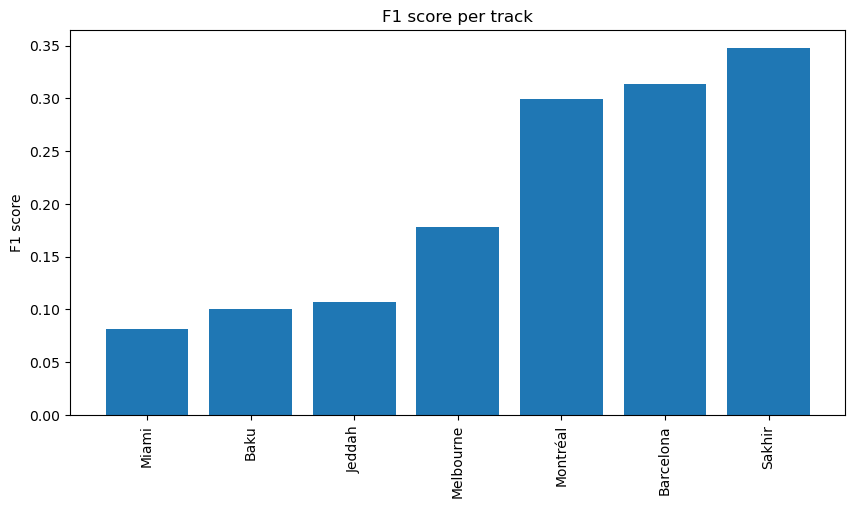

In [21]:
# plot the results
f1_scores.sort(key=lambda x: x[1], reverse=True)
f1_scores = f1_scores[:10]
f1_scores = list(reversed(f1_scores))
plt.figure(figsize=(10, 5))
plt.bar([x[0] for x in f1_scores], [x[1] for x in f1_scores])
plt.xticks(rotation=90)
plt.title('F1 score per track')
plt.ylabel('F1 score')
plt.savefig(os.path.join(figures_path, 'f1_score_per_track.svg'), format='svg')
plt.show()

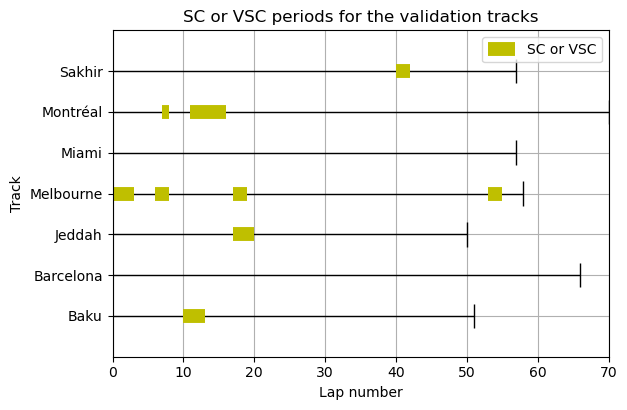

In [22]:
# Get the driver number of a driver who finished the race
drivers_number = data.groupby(['Track', 'DriverNumber']).filter(
    lambda x: x['LapNumber'].max() == x['TotalLaps'].max()
).groupby(['Track']).first()['DriverNumber']

import numpy as np

def findones(a):
    isone = np.concatenate(([0], a, [0]))
    absdiff = np.abs(np.diff(isone))
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return np.clip(ranges, 0, len(a) - 1)

def plotbooleans(ax, dictofbool):
    ax.set_ylim([-1, len(dictofbool)])
    ax.set_yticks(np.arange(len(dictofbool.keys())))
    ax.set_yticklabels(dictofbool.keys())
    ax.set_xlim([0, max([len(x) for x in dictofbool.values()])])

    for i, (key, value) in enumerate(dictofbool.items()):
        indexes = findones(value)
        # create a vertical line for the last lap
        ax.vlines(x=len(value), ymin=i-0.3, ymax=i+0.3, linewidth=1, colors='k')
        ax.hlines(y=i, xmin=0, xmax=len(value), linewidth=1, colors='k')

        for i2, idx in enumerate(indexes):
            if idx[0] == idx[1]:
                idx[1] = idx[1]+1
            if i+i2 == 0: # add label
                ax.hlines(y=i, xmin=idx[0], xmax=idx[1], linewidth=10, colors='y', label='SC or VSC')
            else:
                ax.hlines(y=i, xmin=idx[0], xmax=idx[1], linewidth=10, colors='y')
    return ax

fig, ax = plt.subplots()
plot_data = {}
for track, driver_number in drivers_number.items():
    laps_of_driver = data.groupby(['Track', 'DriverNumber']).get_group((track, driver_number))
    sc_vsc = process_trackStatus(laps_of_driver)[['SC', 'VSC']]
    sc_or_vsc = [True if sc == True or vsc == True else False for sc, vsc in sc_vsc.values]
    plot_data[track] = sc_or_vsc
    
plotbooleans(ax, plot_data)
plt.grid()
plt.subplots_adjust(bottom=0.2)
plt.title('SC or VSC periods for the validation tracks')
plt.xlabel('Lap number')
plt.ylabel('Track')
plt.legend()
plt.savefig(os.path.join(figures_path, 'sc_or_vsc_periods.svg'), format='svg')
plt.show()

In [23]:
m = preprocess_new_data(data, encoder).query('Track_Melbourne == 1')
m

,LapNumber,LapTime,TyreLife,Stint,DistanceToDriverAhead,NumberOfPitStops,Position,GapToLeader,IntervalToPositionAhead,LapsToLeader,TotalLaps,Year,Green,Yellow,SC,Red,VSC,SC_ending,is_pitting,Compound_HARD,Compound_INTERMEDIATE,Compound_MEDIUM,Compound_SOFT,Compound_WET,Track_Abu Dhabi,Track_Al Daayen,Track_Austin,Track_Baku,Track_Barcelona,Track_Budapest,Track_Hockenheim,Track_Imola,Track_Istanbul,Track_Jeddah,Track_Le Castellet,Track_Marina Bay,Track_Melbourne,Track_Mexico City,Track_Miami,Track_Monaco,Track_Monte-Carlo,Track_Montmeló,Track_Montreal,Track_Montréal,Track_Monza,Track_Mugello,Track_Nürburg,Track_Portimão,Track_Sakhir,Track_Shanghai,Track_Silverstone,Track_Sochi,Track_Spa,Track_Spa-Francorchamps,Track_Spielberg,Track_Suzuka,Track_São Paulo,Track_Yas Island,Track_Zandvoort
19,2,133.298004,2,1,-1.000000,0,1,0.000000,0.000,0,58,2023,False,False,True,False,False,False,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,2,132.287003,2,1,113.586670,0,2,1.364000,1.364,0,58,2023,False,False,True,False,False,False,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,2,132.104996,2,1,69.518890,0,3,3.164000,1.055,0,58,2023,False,False,True,False,False,False,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,2,131.410995,2,1,111.182220,0,4,4.125000,1.601,0,58,2023,False,False,True,False,False,False,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,2,130.727997,3,1,22.018055,0,5,5.887000,1.112,0,58,2023,False,False,True,False,False,False,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,56,-1.000000,5,3,-1.000000,2,3,38.713001,0.445,0,58,2023,True,False,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
970,57,-1.000000,5,3,115.376663,2,1,0.000000,0.000,0,58,2023,False,True,False,True,False,False,True,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
971,57,-1.000000,6,3,186.531387,2,3,13.109000,1.025,0,58,2023,False,True,False,True,False,False,True,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
972,57,-1.000000,6,4,171.282227,3,4,1.789000,0.984,0,58,2023,False,True,False,True,False,False,True,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
m[m['LapTime'].isna()]

,LapNumber,LapTime,TyreLife,Stint,DistanceToDriverAhead,NumberOfPitStops,Position,GapToLeader,IntervalToPositionAhead,LapsToLeader,TotalLaps,Year,Green,Yellow,SC,Red,VSC,SC_ending,is_pitting,Compound_HARD,Compound_INTERMEDIATE,Compound_MEDIUM,Compound_SOFT,Compound_WET,Track_Abu Dhabi,Track_Al Daayen,Track_Austin,Track_Baku,Track_Barcelona,Track_Budapest,Track_Hockenheim,Track_Imola,Track_Istanbul,Track_Jeddah,Track_Le Castellet,Track_Marina Bay,Track_Melbourne,Track_Mexico City,Track_Miami,Track_Monaco,Track_Monte-Carlo,Track_Montmeló,Track_Montreal,Track_Montréal,Track_Monza,Track_Mugello,Track_Nürburg,Track_Portimão,Track_Sakhir,Track_Shanghai,Track_Silverstone,Track_Sochi,Track_Spa,Track_Spa-Francorchamps,Track_Spielberg,Track_Suzuka,Track_São Paulo,Track_Yas Island,Track_Zandvoort


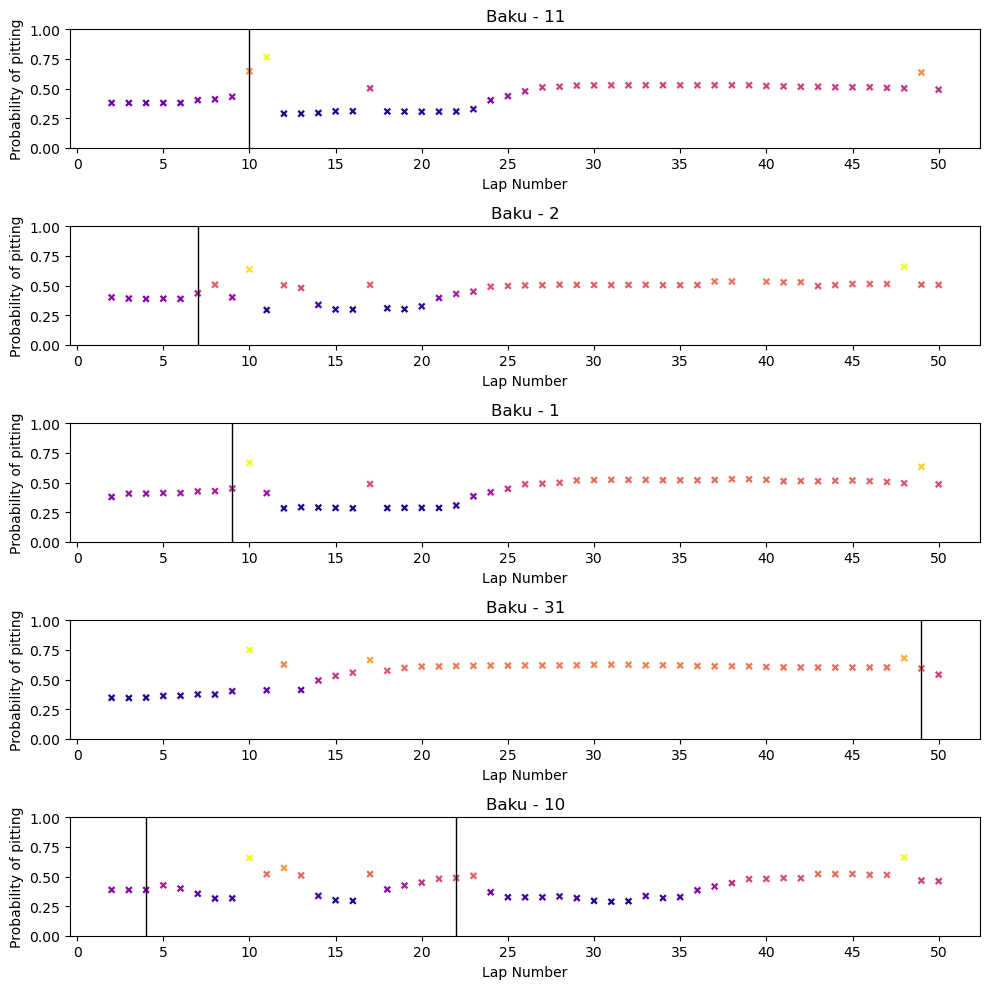

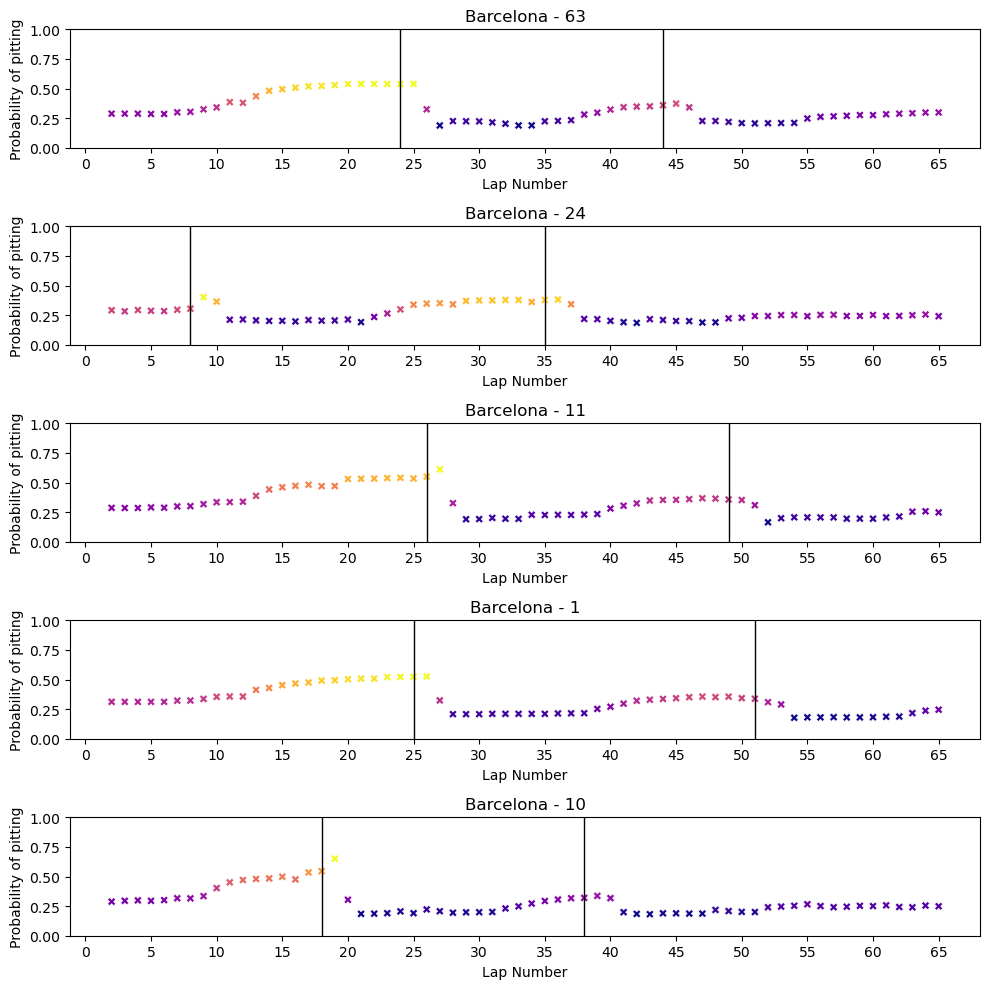

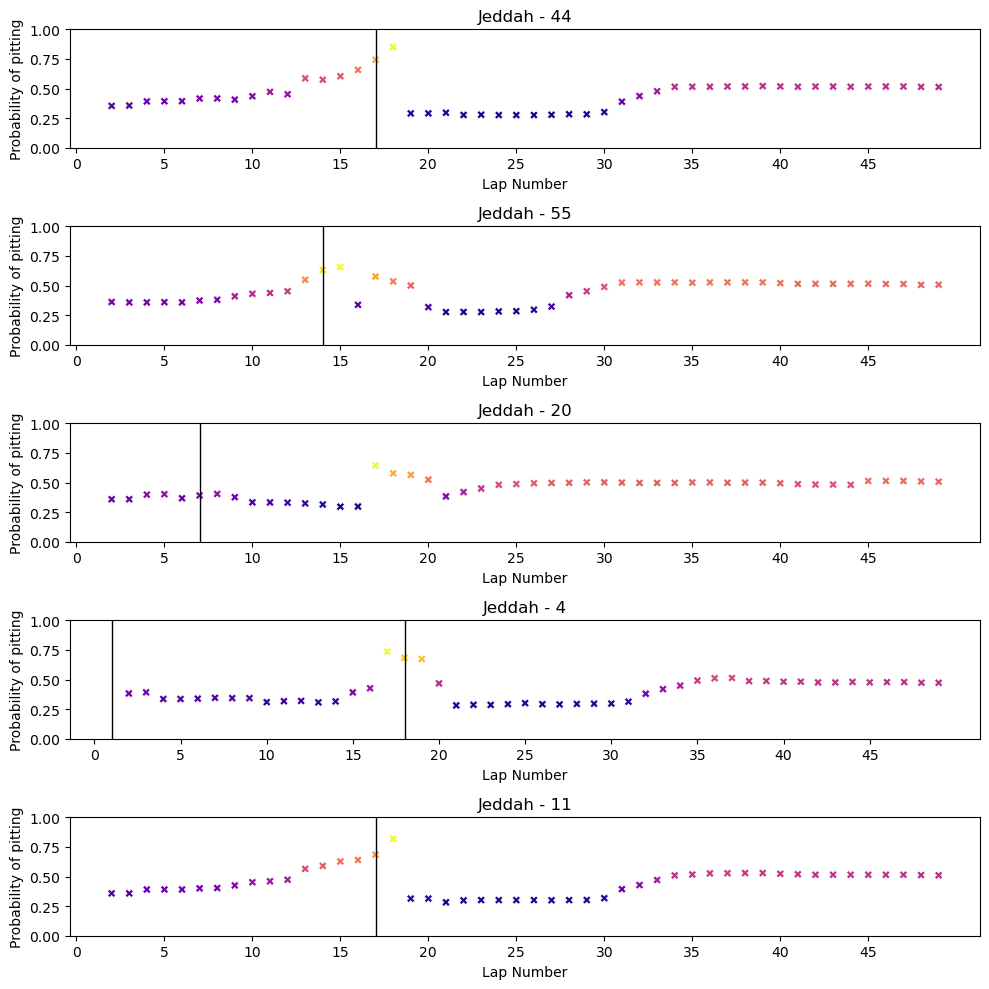

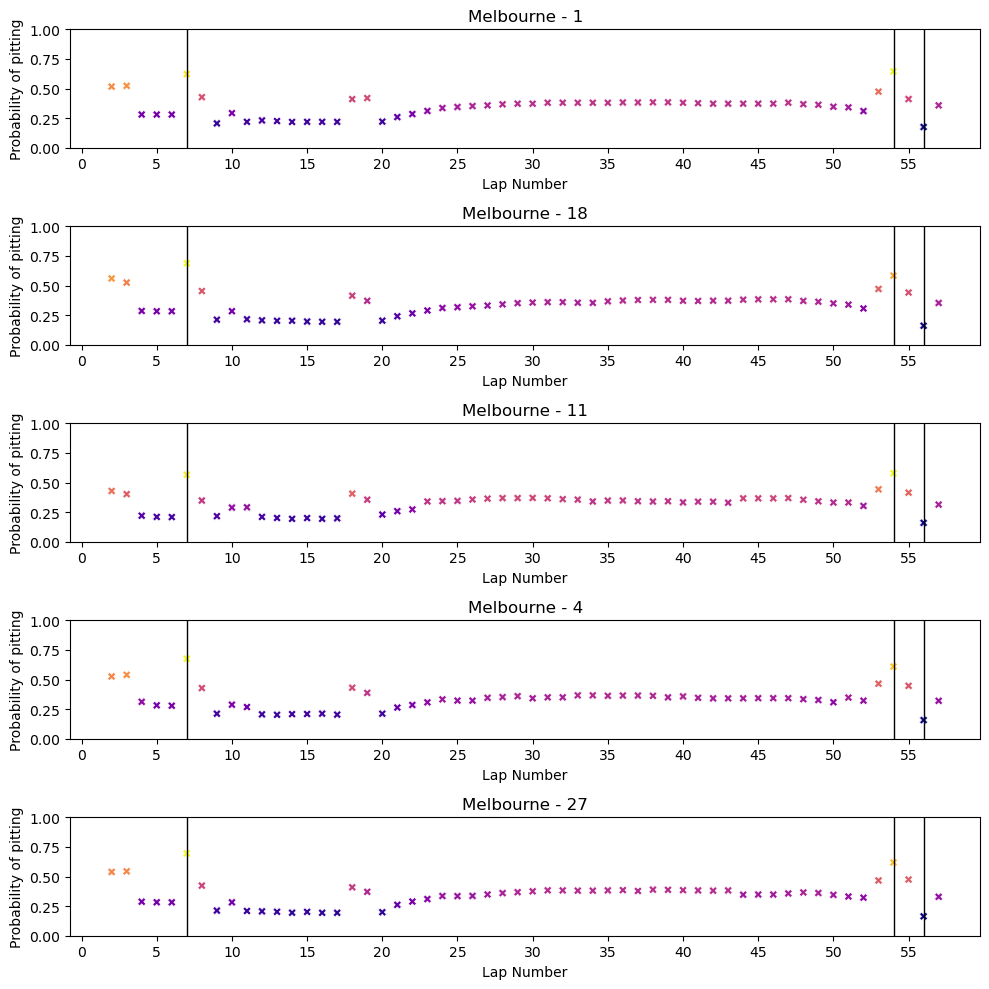

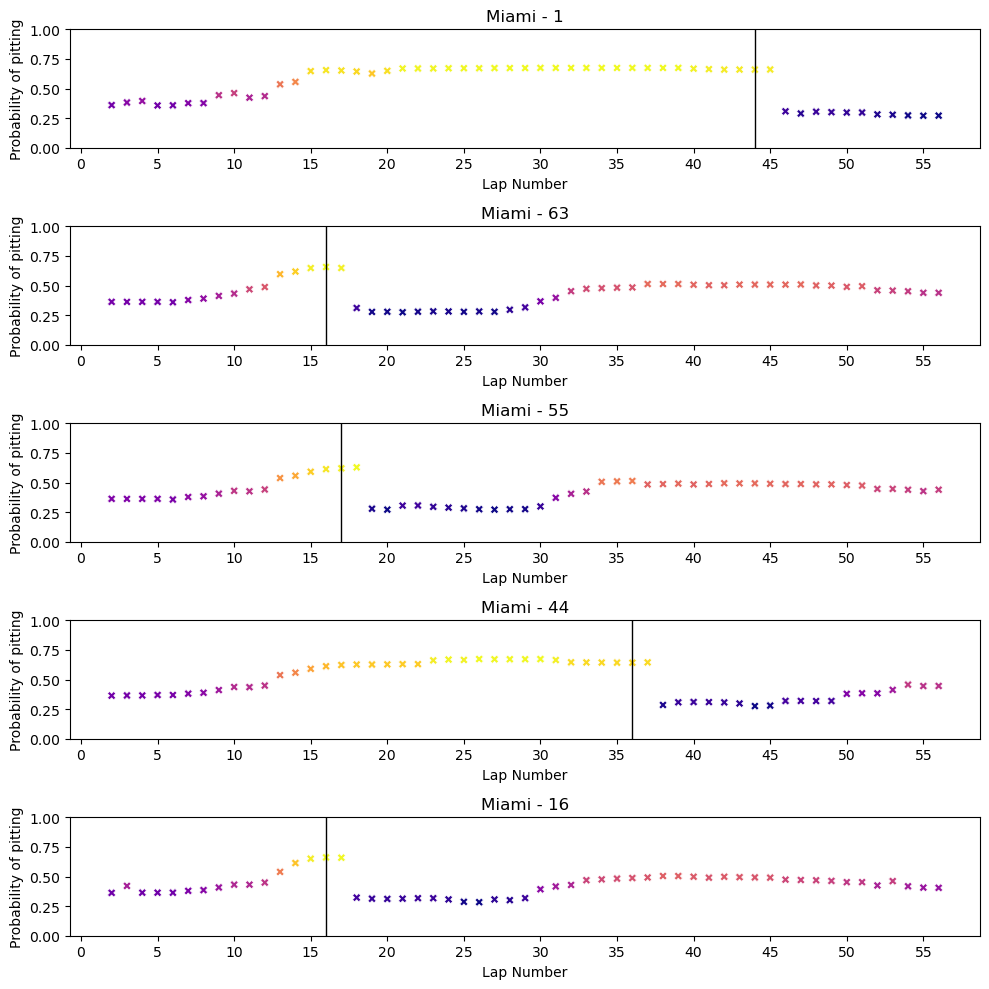

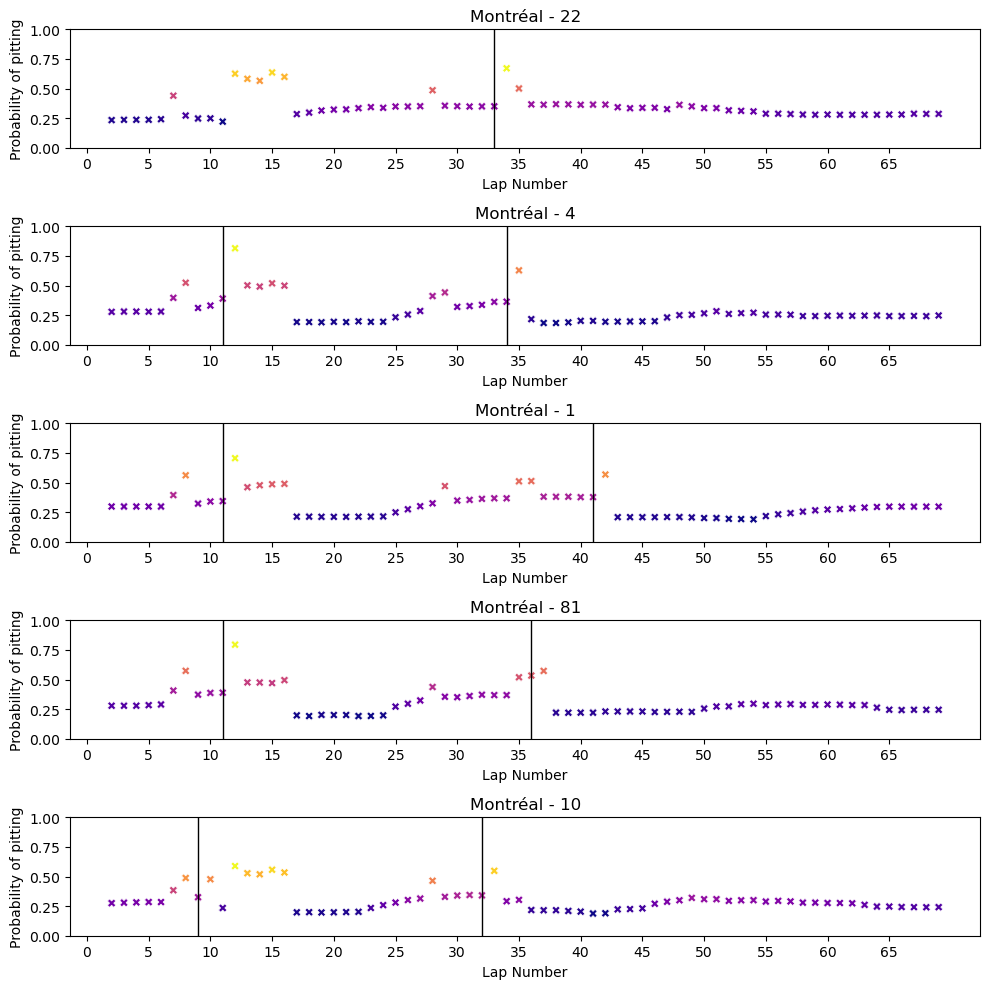

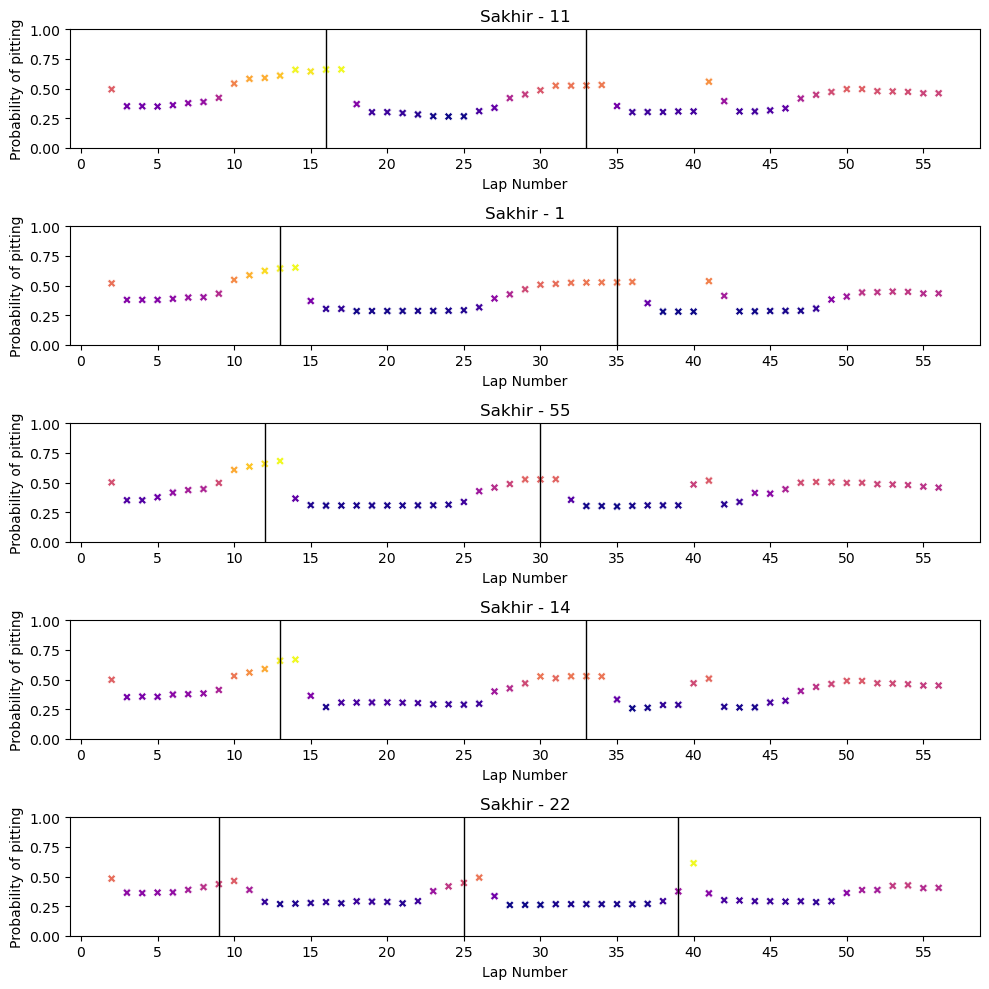

In [25]:
import matplotlib.patches as mpatches

def plot_predictions_by_lapNumber(ax, x_test, y_test, ypred, proba, title=None):

    sns.scatterplot(x=x_test['LapNumber'], y=proba, palette='plasma', hue=proba, marker='X', legend=False, ax=ax)
    ax.set_xlabel('Lap Number')
    ax.set_xticks(np.arange(0, x_test['TotalLaps'].max(), 5))
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability of pitting')
    #indexes = [y.index for y in y_test if y == 1]
    indexes = np.where(y_test == 1)
    for idx in indexes:
        ax.vlines(x=idx+1, ymin=0, ymax=1, linewidth=1, colors='k')
        #ax.hlines(y=0, xmin=idx[0], xmax=idx[1], linewidth=1, colors='k')
    if title:
        ax.set_title(title)
    return ax

# Get the driver number of 5 drivers who finished the race
drivers_number = data.groupby(['Track', 'DriverNumber']).filter(
    lambda x: x['LapNumber'].max() == x['TotalLaps'].max()
).groupby(['Track']).nth(list(range(5)))['DriverNumber']


for i, (track, driver_number) in enumerate(drivers_number.items()):
    if i % 5 == 0: # it's a different track so we make a new plot
        fig, axes = plt.subplots(5, 1, figsize=(10, 10))
    ax = axes[i % 5]
    laps_of_driver = data.groupby(['Track', 'DriverNumber']).get_group((track, driver_number))
    preprocessed_data_i = preprocess_new_data(laps_of_driver, encoder)
    preprocessed_data_i.dropna(inplace=True)
    
    # remove the target
    x_validation_i = preprocessed_data_i.drop(['is_pitting'], axis=1)
    y_validation_i = preprocessed_data_i['is_pitting']

    # predict
    y_pred_i = model.predict(x_validation_i)
    proba = model.predict_proba(x_validation_i)[:, 1]

    # plot
    ax = plot_predictions_by_lapNumber(ax, x_validation_i, y_validation_i, y_pred_i, proba, title=f'{track} - {driver_number}')
    if i % 5 == 4:
        plt.tight_layout()
        plt.savefig(os.path.join(figures_path, f'predictions_by_lapNumber_{i}.svg'), format='svg')
        plt.show()

### ROC AUC

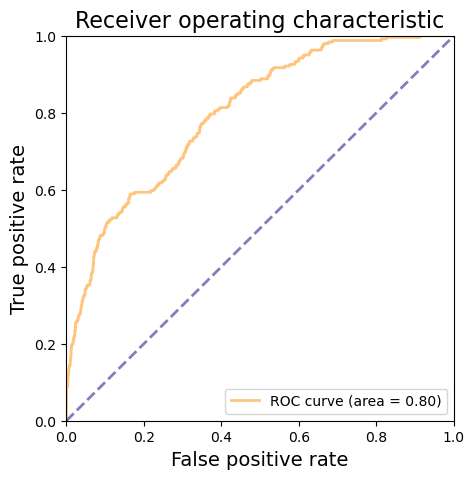

In [26]:
from sklearn.metrics import roc_curve, auc

y_proba = model.predict_proba(x_validation)

fpr, tpr, _ = roc_curve(y_validation, y_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('Receiver operating characteristic', fontsize=16)
plt.legend(loc="lower right")
plt.savefig(os.path.join(figures_path, 'roc_curve.svg'), format='svg')
plt.show()